### Optimisation of a Bioprocess with Multifidelity Bayesian Optimisation


#### Hackathon Breif
This hackathon involves the optimisation of a simulated bioprocess at process scale utilising CHO cells to produce a desired protein. Experimentally, this would involve a resource-intensive screening campaign involving the growth and feeding of cells under precise conditions (temperature, pH, feed amount, fidelity, etc.) to maximize the production of a desired product. This hackathon offers a simulated method of mapping bioprocess input parameters to a final predicted titre concentration: a measure of cell productivity. The simulations are based on various kinetic parameters which are unique to the type of cells used. For the final scoring, a different set of cell kinetic parameters will be used to evaluate your algorithm. 

#### Inputs and Outputs
Inputs to the bioprocess includes 5 vairables: the temperature [°C], pH and the concentration of feed [mM] at 3 different timepoints over 150 minutes. The output is the concentration of the titre (desired product) [g/L]. The goal is to obtain the input variables that correspond to the highest obtained titre. 

The bounds of the inputs are as follows: 

```
temperature [°C]               -> 30 - 40
pH                             -> 6 - 8
first feed concentration [mM]  -> 0 - 50
second feed concentration [mM] -> 0 - 50
third feed concentration [mM]  -> 0 - 50
```

#### Fidelities and Running the simulation
The simulations can be perfomed at 3 levels of fidelities with an associated accuracy and costs. These fidelities corresponds to a different reactor type and scale used. 

```
Lowest fideility: 3L reactor with 1 feeding timepoint at 60 mins.
Realtive cost: 10
Remarks: The feeding concentration is taken as the second feed concentration. Lowest accuracy, but also lowest cost. 

Middle fidelity: 3L reactor with 3 feeding timepoints at 40, 80, 120 mins.
Relative cost: 575
Remarks: -

Highest fidelity: 15L reactor with 3 feeding timepoints at 40, 80, 120 mins.
Relative cost: 2100
Remarks: Highest accuracy but high cost.
```

To run an experiment, one can use the `conduct_experiment(X)` function -> this is your objective function. The inputs to this function is a matrix of shape (N, 6) where N is the number of data points and 6 refers to the total number of variables in the following order: `[temperature, pH, feed1, feed2, feed3, fidelity]`. The fidelities are refered to as integers where `0` corresponds to the lowest fidelity, `1` with the middle and `2` with the highest fidelity. An example is shown below. 

``` python
import numpy as np
from C_Bioprocess_Utils.virtual_lab import conduct_experiment


def obj_func(X):
	return (-np.array(conduct_experiment(X))) #negative placed if optimisation performed is minimisation

X_initial = np.array([[33, 6.25, 10, 20, 20, 0],
                      [38, 8, 20, 10, 20, 0]])
Y_initial = conduct_experiment(X_initial)
print(Y_initial)
```

#### Goal and Submission
Your goal is to develop a Bayesian Optimisation class to obtain the set of inputs which maximizes the titre. You have a **budget of 10000** (observe the cost of running each fidelity), a maximum runtime (on the intructor's computer - be aware of how large the search space becomes especially with 6 dimensions!) and starting with a maximum of 6 training points. (Remember, you have to have at least 2 points for each variable for the covariance matrix to be calculated.)

Please submit your BO class (and GP class) along with the execution block as a .py file to the instructor. A different cell type (with different simulation parameters and maxima) will be used for scoring.

This hackathon will be scored based on the sum of the titre concentration obtained. The score will be penalised by your algorithm's runtime in seconds. 

You must stay within the allocated budget! This will be checked, and if exceeded, your submission will be disqualified!

#### Goal and Submission
Your goal is to develop a Bayesian Optimisation class to obtain the set of inputs which **maximizes the titre at the highest fideility**. You have a **budget of 15000** (observe the cost of running each fidelity) and starting with a maximum of 7 training points that is not a part of the budget. (Remember, you have to have at least 2 points for each variable for the covariance matrix to be calculated.)

Please submit your BO class (and GP class) along with the execution block as a .py file to the instructor. A different cell type (with different simulation parameters and maxima) will be used for scoring.

This hackathon will be scored based on maximum titre concentration obtained at the highest fidelity. You must stay within the allocated budget! This will be checked, and if exceeded, your submission will be disqualified!

#### Form of the BO class and execution block
You are allowed to write your own BO class or make modifications to any of the previously seen BO classes. 

You must include the attributes `self.X` and `self.Y` corresponding to all of your evaluated inputs and outputs as this will be used to retrive the information used for scoring. 

```python
#submission should look something like the following
class GP: #if you have any separate classes other than the BO class
    def __init__(self, ...):
        ...
#BO class
class BO: 
    def __init__(self, ...):
        self.X = #training data which the evaluated data is to be appended
        self.Y = #evaluated via the objective function using self.X

# BO Execution Block
X_training = [...]
X_seachspace = [...]

BO_m = BO(...)
```

#### Guidance (Intermediate - Multi-batch Bayesian Optimsation) 
You can construct a single-sequential or batch BO algorithm to perform the optimisation. The lowest fidelity experiments do not offer accurate outcomes and you have to choose how many number of expeirments for each fidelity to be performed such that you do not exceed your allocated budget. To link between each fideility, one could perform optimisation on the lower fidilities and then translate the best input conditions to run the highest fidelity experiment. 

#### Guidance (Advanced - Multi-fidelity Bayesian Optimisation)
You can develop a multi-fidelity Bayesian Optimisation algorithm to perform the optimisation. Since the score is based on the highest titre concentration of the highest fidelity, it might be beneficial if you constrain (at least) the last experiment to be run with the highest fidelity - this mitigates the risk that your algorithm does not perform any experiments with the highest fidelity. A basic MFBO algorithm could be created by modifying the acquisition function to one that is cost aware. For example: we have previously used Lower Confidence Bound to balance exploration and exploitation of the search space (see notebook section C). To make this cost aware, we can scale the values obtained from LCB by the cost.

```python
    def MF_lower_confidence_bound(...):
        lower_std = Ysearchspace_mean - acquisition_hyperparam[0]*np.sqrt(Ysearchspace_std)
        # mf_lower_std = lower_std / assocated cost for each simulation
        return (X_searchspace[np.argmin(mf_lower_std)])
```

#### Feedback and Scoring Example
Once your algorithm is submitted to the instructor, you can request for some feedback on the performance of your algorithm. The final score will be calculated based on the maximum titre concentration obtained from the highest fidelity. 3 plots will be produced to showcase the performance of your algorithm and the performance against the cohort. Example: 

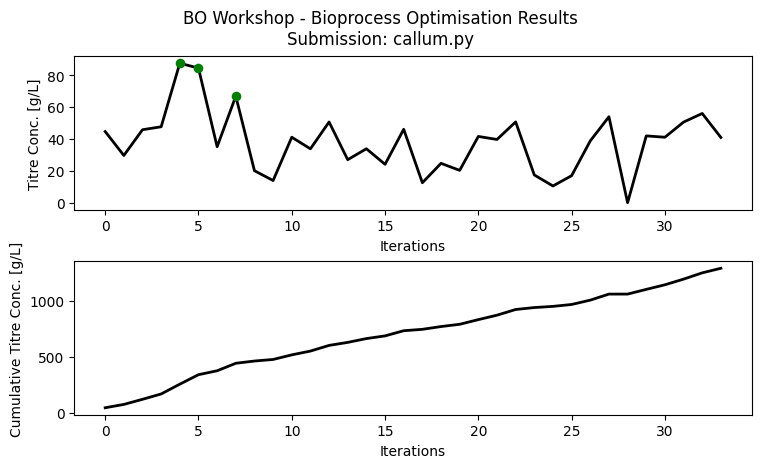
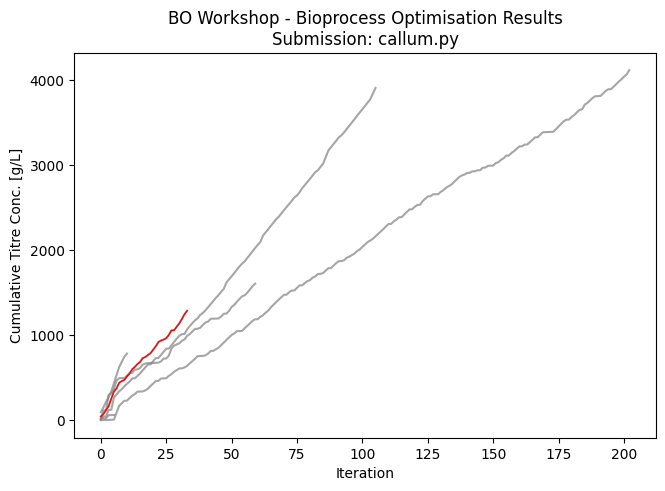
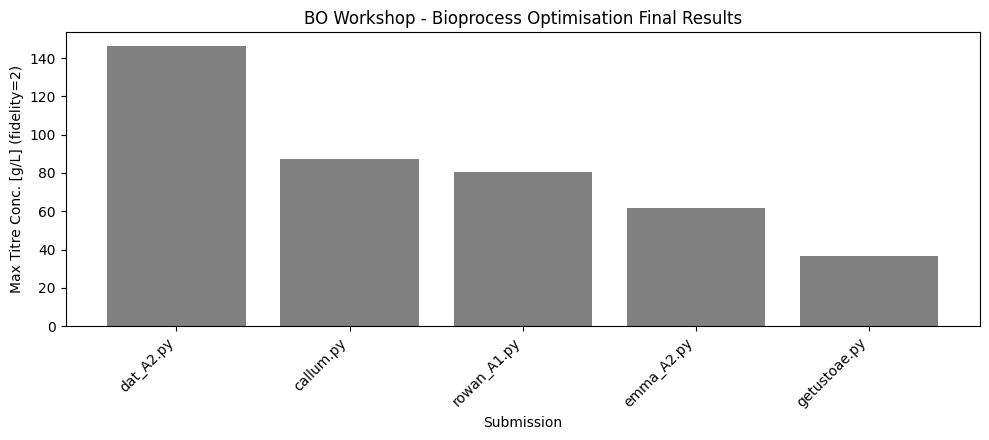

#### Package Imports

Packages are limited to the the ones listed in the package cell - Talk to one of the intructors to ask if it is possible to import other packages

In [4]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import plotly.graph_objs as go
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint
from sklearn.decomposition import PCA
import math
import time
import sobol_seq
import torch
import gpytorch
import copy

from C_Bioprocess_Utils.virtual_lab import conduct_experiment

In [3]:
# Check that this runs without errors!

def obj_func(X):
	return (-np.array(conduct_experiment(X))) #negative placed if optimisation performed is minimisation

X_initial = np.array([[33, 6.25, 10, 20, 20, 0],
                      [38, 8, 20, 10, 20, 0]])
Y_initial = conduct_experiment(X_initial)
print(Y_initial)

[10.35526663386677, 1.3630867118273524]
